In [15]:
import pandas as pd, numpy as np, joblib, yfinance as yf, matplotlib.pyplot as plt
import seaborn as sns
import pathlib, sys, warnings
from scipy.stats import kurtosis, skew

warnings.simplefilter("ignore", FutureWarning)

ROOT = pathlib.Path().resolve().parent.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import config as cfg



In [17]:
START = "2019-01-02"
END = pd.Timestamp.today().normalize()

gspc = yf.download("^GSPC", start=START, end=END, progress=False)
price_gs = gspc["Adj Close"] if "Adj Close" in gspc.columns else gspc["Close"]
calendar = price_gs.dropna().index



In [19]:
bt_path = cfg.RESULT / "backtest_cnn5d.pkl"
res_df = joblib.load(bt_path)

ret_sys = res_df["retorno"].reindex(calendar).fillna(0.0)
print("✅ Retornos del sistema cargados:", ret_sys.shape)



✅ Retornos del sistema cargados: (1632,)


In [21]:
tickers = ["SPY", "BIL"]
raw_bench = yf.download(tickers, start=START, end=END, progress=False)

if isinstance(raw_bench.columns, pd.MultiIndex):
    prices_b = raw_bench["Adj Close"] if "Adj Close" in raw_bench.columns.levels[0] else raw_bench["Close"]
else:
    prices_b = raw_bench

prices_b = prices_b.ffill()
ret_bench = np.log(prices_b / prices_b.shift(1)).reindex(calendar).dropna()

ret_spy = ret_bench["SPY"]
ret_cash = ret_bench["BIL"]
print("✅ Benchmarks cargados:", ret_bench.shape)


✅ Benchmarks cargados: (1631, 2)


In [23]:
def stats(r):
    ann = np.sqrt(252)
    w = (1 + r).cumprod()
    return {
        "Rentabilidad (%)" : (w.iloc[-1] - 1) * 100,
        "Volatilidad (%)" : r.std(ddof=1) * ann * 100,
        "Sharpe" : r.mean() / r.std(ddof=1) * ann,
        "MaxDD (%)" : (w.cummax() - w).max() * 100,
        "Asimetría" : skew(r),
        "Curtosis" : kurtosis(r)
    }


In [25]:
tabla = pd.DataFrame({
    "CNN5D": stats(ret_sys),
    "SPY"  : stats(ret_spy),
    "BIL"  : stats(ret_cash)
}).T.round(2)

print("\n── Métricas 2019-hoy (CNN5D + NSGA-II) ──")
display(tabla)



── Métricas 2019-hoy (CNN5D + NSGA-II) ──


,Rentabilidad (%),Volatilidad (%),Sharpe,MaxDD (%),Asimetría,Curtosis
CNN5D,143.24,11.16,1.29,37.05,1.07,57.05
SPY,138.52,20.37,0.76,48.90,-0.57,13.57
BIL,16.93,0.25,9.54,0.21,0.85,1.27


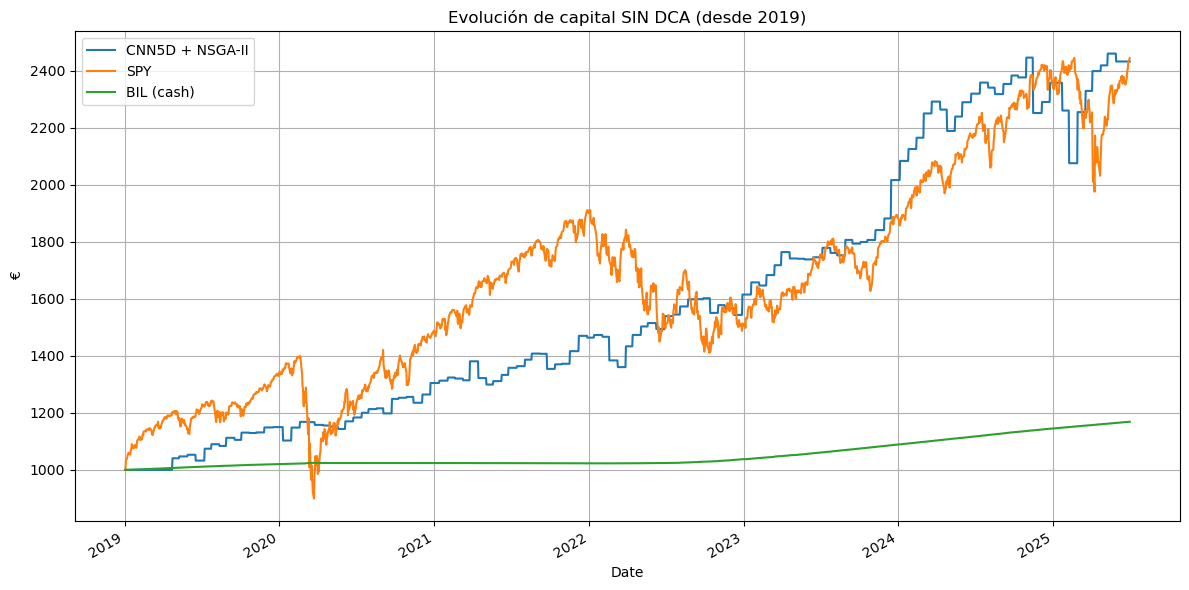

In [27]:
capital_ini = 1000
wealth_cnn_ini = (1 + ret_sys).cumprod() * capital_ini
wealth_spy_ini = (1 + ret_spy).cumprod() / (1 + ret_spy).cumprod().iloc[0] * capital_ini
wealth_cash_ini = (1 + ret_cash).cumprod() / (1 + ret_cash).cumprod().iloc[0] * capital_ini

plt.figure(figsize=(12,6))
wealth_cnn_ini.plot(label='CNN5D + NSGA-II')
wealth_spy_ini.plot(label='SPY')
wealth_cash_ini.plot(label='BIL (cash)')
plt.title('Evolución de capital SIN DCA (desde 2019)')
plt.ylabel('€')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


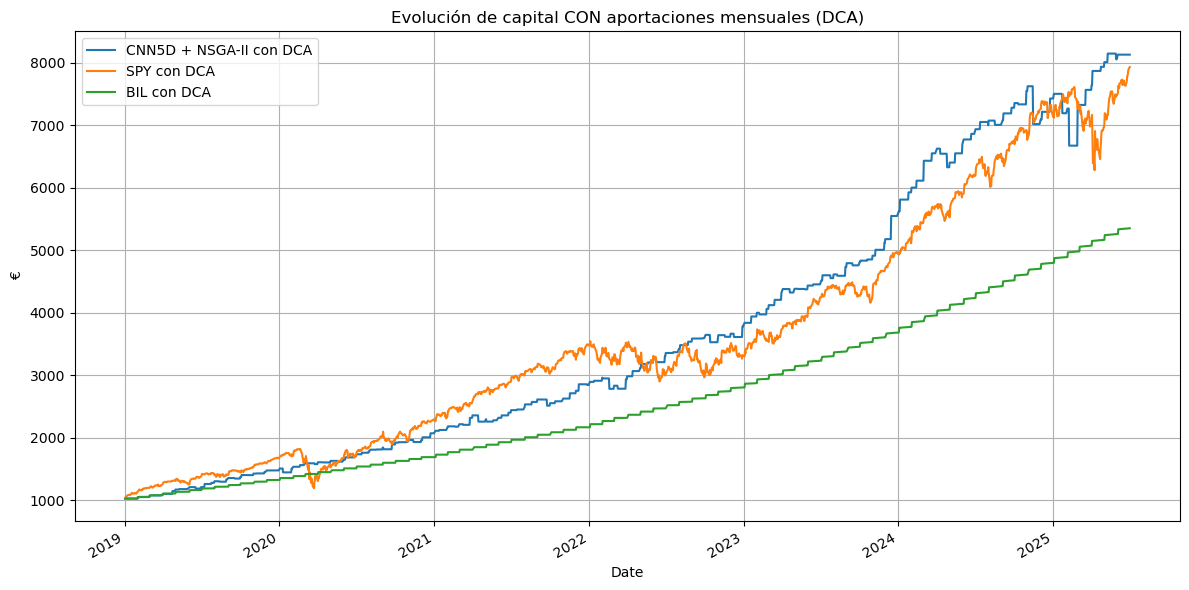

In [29]:
aport_mes = {2019:25, 2020:30, 2021:40, 2022:50, 2023:60, 2024:75, 2025:75}
aport = pd.Series(0, index=ret_sys.index)
primer_dia_mes = ret_sys.index.to_series().groupby(ret_sys.index.to_period('M')).first()

for fecha in primer_dia_mes:
    if fecha.year in aport_mes:
        aport.at[fecha] = aport_mes[fecha.year]

def curva_con_aportes(ret_series, capital_ini, aport_series):
    wealth = pd.Series(index=ret_series.index, dtype=float)
    wealth.iloc[0] = capital_ini + aport_series.iloc[0]
    for t in range(1, len(ret_series)):
        wealth.iloc[t] = (wealth.iloc[t-1] + aport_series.iloc[t]) * (1 + ret_series.iloc[t])
    return wealth

wealth_cnn_dca = curva_con_aportes(ret_sys, capital_ini, aport)
wealth_spy_dca = curva_con_aportes(ret_spy, capital_ini, aport)
wealth_cash_dca = curva_con_aportes(ret_cash, capital_ini, aport)

plt.figure(figsize=(12,6))
wealth_cnn_dca.plot(label='CNN5D + NSGA-II con DCA')
wealth_spy_dca.plot(label='SPY con DCA')
wealth_cash_dca.plot(label='BIL con DCA')
plt.title('Evolución de capital CON aportaciones mensuales (DCA)')
plt.ylabel('€')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


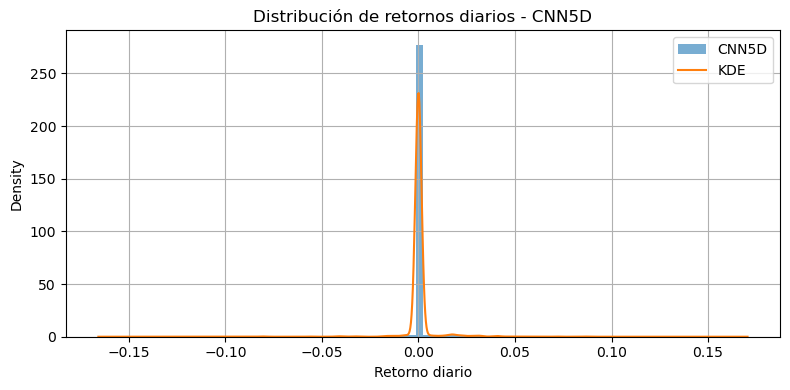

In [31]:
plt.figure(figsize=(8,4))
ret_sys.hist(bins=50, density=True, alpha=0.6, label="CNN5D")
ret_sys.plot(kind="kde", label="KDE")
plt.title("Distribución de retornos diarios - CNN5D")
plt.xlabel("Retorno diario")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


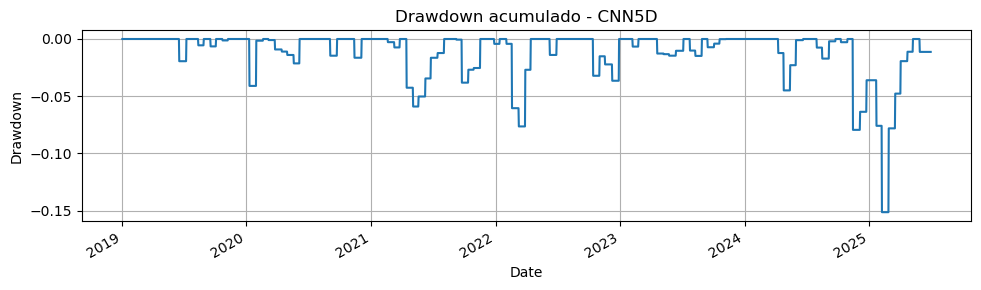

In [33]:
cum_returns = (1 + ret_sys).cumprod()
rolling_max = cum_returns.cummax()
drawdown = cum_returns / rolling_max - 1

plt.figure(figsize=(10,3))
drawdown.plot()
plt.title("Drawdown acumulado - CNN5D")
plt.ylabel("Drawdown")
plt.grid()
plt.tight_layout()
plt.show()


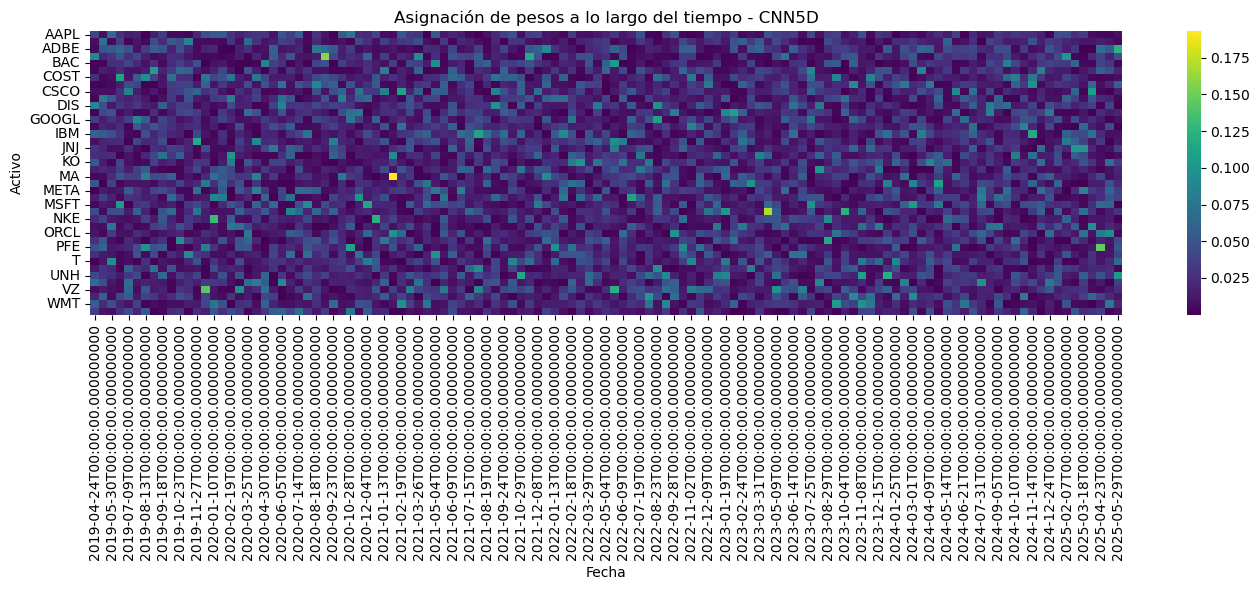

In [35]:
df_prices = pd.read_parquet(cfg.DATA / "raw" / "prices.parquet")
tickers = df_prices.columns[:res_df["w_star"].iloc[0].shape[0]]

df_w = pd.DataFrame(
    [r["w_star"] for r in res_df.dropna().to_dict(orient='records')],
    index=res_df.dropna().index,
    columns=tickers
)

plt.figure(figsize=(14,6))
sns.heatmap(df_w.T, cmap="viridis", cbar=True)
plt.title("Asignación de pesos a lo largo del tiempo - CNN5D")
plt.xlabel("Fecha")
plt.ylabel("Activo")
plt.tight_layout()
plt.show()


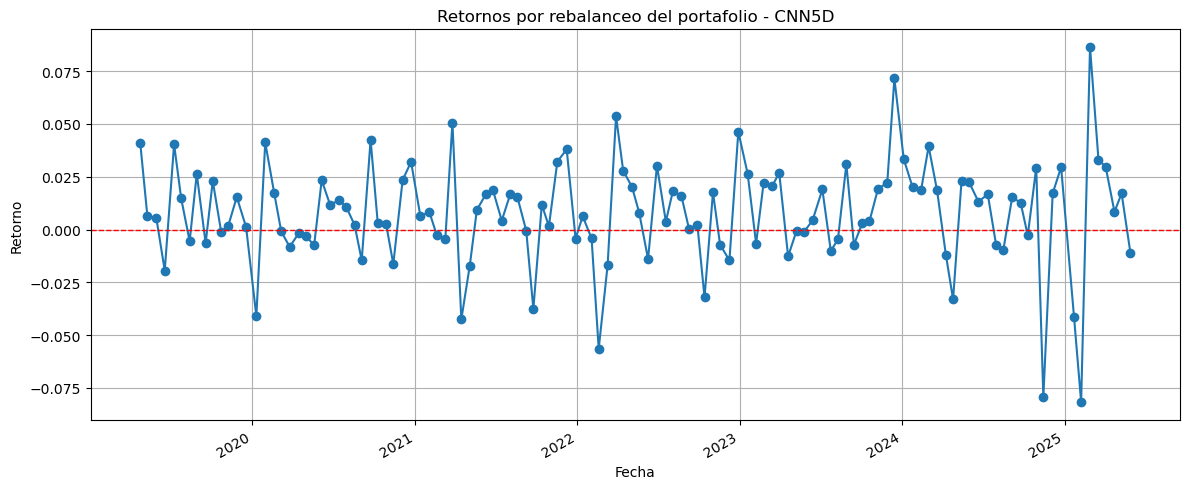

In [37]:
plt.figure(figsize=(12, 5))
res_df["retorno"].plot(marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Retornos por rebalanceo del portafolio - CNN5D")
plt.ylabel("Retorno")
plt.xlabel("Fecha")
plt.grid(True)
plt.tight_layout()
plt.show()
